In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import mpl_lego as mplego
import pandas as pd

from hatespeech import keys, utils
from IPython.display import Markdown
from scipy.stats import f_oneway, kruskal

%matplotlib inline

In [2]:
mplego.style.use_latex_style()

In [3]:
exp = "22"
base_path = os.path.join(os.environ['HOME'], 'projects/hatespeech-2021-fairml')
data_path = "~/data/hatespeech/unfiltered_ratings.feather"
rater_quality_path = "~/data/hatespeech/rater_quality_check.csv"
results_path = os.path.join(base_path, f'scaling/experiments/exp{exp}')

In [4]:
data = pd.read_feather(data_path).rename(columns={'violence_phys': 'violence'})
# Remove all rows in which some item is missing
data = utils.filter_missing_items(data)
# Remove all rows in which the rater is not up to sufficient quality
rater_quality = pd.read_csv(rater_quality_path)
data = utils.filter_annotator_quality(data, rater_quality)
# Recode item responses
data = utils.recode_responses(
    data,
    insult={1: 0, 2: 1, 3: 2, 4: 3},
    humiliate={1: 0, 2: 0, 3: 1, 4: 2},
    status={1: 0, 2: 0, 3: 1, 4: 1},
    dehumanize={1: 0, 2: 0, 3: 1, 4: 1},
    violence={1: 0, 2: 0, 3: 1, 4: 1},
    genocide={1: 0, 2: 0, 3: 1, 4: 1},
    attack_defend={1: 0, 2: 1, 3: 2, 4: 3},
    hatespeech={1: 0, 2: 1})
# Only get comments targeting black / white people
data = data[data['target_race_white'] | data['target_race_black']]
data = data[data[keys.target_race_cols].sum(axis=1) == 1]
data['target_race'] = np.where(data['target_race_white'], 1, 2)

In [5]:
out_path = os.path.join(results_path, f"exp{exp}_out.txt")

In [6]:
with open(out_path) as f:
    lines = f.readlines()

In [7]:
bias_lines = lines[17588:30364]

In [8]:
bias_cut = bias_lines[4:-7]

In [9]:
n_samples = len(bias_cut)
observed = np.zeros(n_samples)
expected = np.zeros(n_samples)
bias_size = np.zeros(n_samples)
t_stats = np.zeros(n_samples)
p_vals = np.zeros(n_samples)
labeler_id = np.zeros(n_samples)
measure = np.zeros(n_samples)
race = np.zeros(n_samples)

for idx, line in enumerate(bias_cut):
    processed = line.replace('|', ' ').replace('>', ' ').replace('<', ' ').split()
    observed[idx] = float(processed[0])
    expected[idx] = float(processed[1])
    bias_size[idx] = float(processed[4])
    t_stats[idx] = float(processed[6])
    p_vals[idx] = float(processed[8])
    labeler_id[idx] = int(processed[13])
    measure = float(processed[14])
    if processed[16] == 'white':
        race[idx] = 0
    elif processed[16] == 'black':
        race[idx] = 1

In [10]:
df = pd.DataFrame({
    'observed': observed,
    'expected': expected,
    'bias': bias_size,
    't_statistics': t_stats,
    'p_values': p_vals,
    'labeler_id': labeler_id,
    'measure': measure,
    'race': race}).astype({'labeler_id': int})

In [11]:
df['annotator_race'] = 0
subview = data[data['labeler_id'].isin(df['labeler_id'])].drop_duplicates('labeler_id')
df.loc[df['labeler_id'].isin(subview[subview['annotator_race_black']]['labeler_id']), 'annotator_race'] = 1

In [12]:
df['bias_corrected'] = -df['bias']
df['bias_abs'] = df['bias'].abs()
df['annotator_race_name'] = np.where(df['annotator_race'] == 1, 'black', 'white')
df['target_race_name'] = np.where(df['race'] == 1, 'black', 'white')

In [31]:
target_black = df[df['target_race_name'] == 'black']
target_black_sig = target_black[target_black['p_values'] < 0.05]
target_white = df[df['target_race_name'] == 'white']
target_white_sig = target_white[target_white['p_values'] < 0.05]

In [30]:
(target_black[target_black['annotator_race_name'] == 'white']['bias_corrected'] < 0).mean()

0.23321751216122308

In [27]:
(target_white[target_white['annotator_race_name'] == 'black']['bias_corrected'] > 0).mean()

0.4491017964071856

In [35]:
(target_white_sig[target_white_sig['annotator_race_name'] == 'black']['bias_corrected'] < 0).mean()

0.3125

In [71]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

axes[0].bar(
    x=[]
)

(818,)

In [75]:
from scipy.stats import f_oneway, kruskal

f_oneway(
    df[(df['annotator_race'] == 0) & (df['race'] == 0)]['bias_corrected'].values,
    df[(df['annotator_race'] == 1) & (df['race'] == 0)]['bias_corrected'].values)

F_onewayResult(statistic=8.704003943516497, pvalue=0.003190624491126266)

In [41]:
f_oneway(
df[(df['annotator_race'] == 0) & (df['race'] == 1) & (df['p_values'] < 1)]['bias_corrected'],
     df[(df['annotator_race'] == 1) & (df['race'] == 1) & (df['p_values'] < 1)]['bias_corrected'])

F_onewayResult(statistic=9.549641870183601, pvalue=0.0020079678537736046)

In [151]:
np.median(df[(df['annotator_race'] == 1) & (df['race'] == 0) & (df['p_values'] < 0.1)]['bias_corrected'])

0.855

In [80]:
target_black = df[df['race'] == 1].copy()
target_white = df[df['race'] == 0].copy()
common_annotators = target_black[target_black['labeler_id'].isin(target_white['labeler_id'])]['labeler_id'].values

In [90]:
diffs = (target_black[target_black['labeler_id'].isin(common_annotators)].sort_values('labeler_id')['bias_corrected'].reset_index(drop=True)
         - target_white[target_white['labeler_id'].isin(common_annotators)].sort_values('labeler_id')['bias_corrected'].reset_index(drop=True))

In [94]:
interaction_diffs = pd.DataFrame(data={'labeler_id': np.sort(common_annotators), 'interaction_diffs': diffs})

In [96]:
sev_diffs = pd.read_csv('severity_diffs.csv')

In [103]:
ruff = sev_diffs.merge(interaction_diffs, how='inner', on='labeler_id')

In [111]:
np.corrcoef(ruff['severity_diffs'], ruff['interaction_diffs'])

array([[1.        , 0.70916585],
       [0.70916585, 1.        ]])

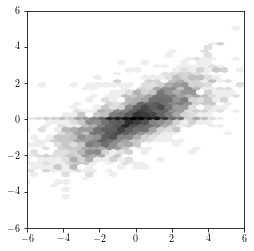

In [124]:
plt.hexbin(ruff['severity_diffs'], ruff['interaction_diffs'], cmap='Greys', bins='log', gridsize=40)
plt.xlim([-6, 6])
plt.ylim([-6, 6])
plt.gca().set_aspect('equal')

In [ ]:
# 5913
# 8133

In [30]:
annotator = 6028
df_comment = data[data['labeler_id'] == annotator][['predict_text', 'comment_id', race_to_col['black'], race_to_col['white']] + items].reset_index(drop=True)
avg_for_comments = pd.merge(
    left=df_comment,
    right=avg_scores,
    how='left',
    on='comment_id',
    suffixes=('_left', ''))[items]
df_comment[items] = df_comment[items] - avg_for_comments

In [172]:
data[data['labeler_id'] == annotator][items]

,sentiment,respect,insult,humiliate,status,dehumanize,violence,genocide,attack_defend,hatespeech
9558,4,3,2,0,0,1,0,0,2,0
20647,4,4,3,1,0,1,1,1,2,0
22461,4,4,3,2,1,1,1,0,3,0
